## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

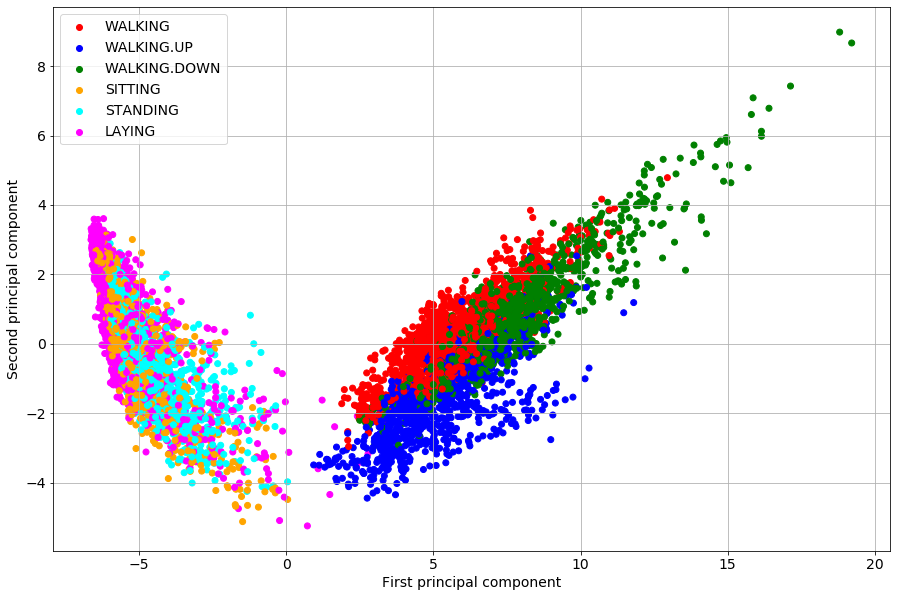

In [3]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [4]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [5]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

# Отчет

Я решил написать и обучить CNN, используя 1D свертки. Я сделал 4 сверточных и 4 пулинговых слоя. Таким образом, при проходе через сетку уменьшается пространственный размер со 128 до 8, а число фильтров увеличивается с 9 до 144. После этого происходит распрямление в вектор, проход через слой с дропаутом и последний, линейный слой. До того, как подать в сетку батчи с данными, тренировочная и тестовая выборки были транспонированы, так как сначала должны идти каналы, а потом пространственные размеры. Кроме того, было убрано одно измерение у y_train и y_test, чтобы их можно было передать в функцию потерь. После обучения было получено accuracy = 0.89. Чтобы улучшить скор, я поменял функции активации с nn.ReLU() на nn.LeakyReLU(), а также увеличил learning_rate с 0.0003 до 0.001. Это позволило получить точность на тесте равную 0.9124

In [6]:
# Your experiments here
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(y_train.shape, y_test.shape)
y_train = torch.squeeze(torch.LongTensor(y_train), axis=1)
y_test = torch.squeeze(torch.LongTensor(y_test), axis=1)
print(y_train.shape, y_test.shape)

(7352, 1) (2947, 1)
torch.Size([7352]) torch.Size([2947])


In [7]:
train_dataset = TensorDataset(torch.tensor(X_train).transpose(1, 2), y_train)
test_dataset = TensorDataset(torch.tensor(X_test).transpose(1, 2), y_test)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=64)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=64)

In [8]:
import torch.nn.functional as f
from torch.optim import lr_scheduler

In [9]:
class OneDConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
        nn.Conv1d(9, 18, kernel_size=2, stride=1, padding=1),
        nn.LeakyReLU(),
        nn.MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1),
        nn.Conv1d(18, 36, kernel_size=2, stride=1, padding=1),
        nn.LeakyReLU(),
        nn.MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1),
        nn.Conv1d(36, 72, kernel_size=2, stride=1, padding=1),
        nn.LeakyReLU(),
        nn.MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1),
        nn.Conv1d(72, 144, kernel_size=2, stride=1, padding=1),
        nn.LeakyReLU(),
        nn.MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1),
        nn.Flatten(),
        nn.Dropout(0.5),
        nn.Linear(1152, 6))
        
    def forward(self, x):
        out = self.model(x)
        return out

In [10]:
net = OneDConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [11]:
for epoch in range(11):
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    scheduler.step()
    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                "train", epoch_loss, epoch_acc))
print("Finished Training")

train Loss: 0.0135 Acc: 0.6474
train Loss: 0.0055 Acc: 0.8505
train Loss: 0.0035 Acc: 0.9129
train Loss: 0.0025 Acc: 0.9353
train Loss: 0.0023 Acc: 0.9438
train Loss: 0.0020 Acc: 0.9484
train Loss: 0.0019 Acc: 0.9495
train Loss: 0.0019 Acc: 0.9533
train Loss: 0.0018 Acc: 0.9528
train Loss: 0.0018 Acc: 0.9538
train Loss: 0.0017 Acc: 0.9558
Finished Training


In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds== labels).sum().item()
print('Accuracy of the network on the test:', correct / total)

Accuracy of the network on the test: 0.9124533423820834
